# Analysis with currents from CMEMS

Here we will use currents from CMEMS to illustrate the use of an advection constrain. A user registered at CMEMS can download model data using the motu tool.
Unfortunately, it is not possible to downloading with a single request a large amount of data with motu and one need to split the request per month (or per day).

In Julia, one could download the current for the Adriatic for example by:

```julia
cmems_username  = "..."
cmems_password  = "..."
basedir = "..."

for dt = DateTime(1987,1,1):Dates.Month(1):DateTime(2018,12,31)
   outname = "currents-" * Dates.format(dt,"yyyy-mm-dd") * ".nc"
   datemin = Dates.format(dt,"yyyy-mm-dd HH:MM:SS")
   datemax = Dates.format(dt + Dates.Month(1) - Dates.Day(1),"yyyy-mm-dd HH:MM:SS")
   command = `python3 -m motuclient  --user $(cmems_username) --pwd $(cmems_password) --date-min $(datemin) --date-max $(datemax)    --motu http://my.cmems-du.eu/motu-web/Motu --service-id MEDSEA_REANALYSIS_PHYS_006_004-TDS --product-id sv03-med-ingv-cur-rean-m  --longitude-min 11.4 --longitude-max 20.1 --latitude-min 38.9 --latitude-max 46.1 --depth-min 0 --depth-max 7000 --variable vozocrtx --variable vomecrty    --out-dir $(basedir) --out-name $outname`
   @show command
   run(command)
end
```

For issues with motu and the downloading, please refer to the [CMEMS forum](http://forum.marine.copernicus.eu/) and in particular: http://forum.marine.copernicus.eu/discussion/202/how-to-download-a-large-amount-of-cmems-data-how-to-perform-a-loop-on-dates-new/p1 and http://marine.copernicus.eu/faq/what-are-the-motu-and-python-requirements/ .
Please pay attention to the supported version of the motu client and python.
Version of the motu client of 1.8.3 and older [will not work](http://marine.copernicus.eu/newsflash/cmems10731-retiring-tls-versions-below-v1-2-immediate-action-required/?idpage=166)



For the example here we use a subset of the CMEMS data for the year 2018:


In [1]:
using NCDatasets
using DIVAnd
using PyPlot
using Dates
using Statistics
using Random
using Printf


varname = "Salinity"
basedir = "./"

"./"

The domain is identifical to the full example notebook.

In [2]:
dx, dy = 0.125, 0.125
lonr = 11.5:dx:20
latr = 39:dy:46
timerange = [Date(1950,1,1),Date(2017,12,31)];

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66,
          75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250,
          275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750,
          800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250,
          1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];
depthr = [0.,10.,20.];

For simplicity we download an already prepared NetCDF velocity.

In [3]:
velfilename = "all-monthly-currents-2018.nc"

if !isfile(velfilename)
    download("https://dox.ulg.ac.be/index.php/s/qJtEotmkCZVqcx8/download",velfilename)
end


yearlist = [1900:2017];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];
monthlist = [[1,2,3]];
TSvelocity = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);


varnames = ("vozocrtx","vomecrty")
outvarnames = ("u","v")
outfilename = joinpath(basedir,"average-currents.nc")

if isfile(outfilename)
    rm(outfilename)
end

# the first argument of DIVAnd.average_files can also be a list of filenames
DIVAnd.average_files([velfilename],varnames,TSvelocity,outfilename,outvarnames)

┌ Info: average vozocrtx
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/utils.jl:904
┌ Info: time instance 1 of 1
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/utils.jl:983
┌ Info: average vomecrty
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/utils.jl:904
┌ Info: time instance 1 of 1
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/utils.jl:983


Load the bathymetry

In [4]:
bathname = "gebco_30sec_8.nc"
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

@time bx,by,b = load_bath(bathname,true,lonr,latr);

aspect_ratio = 1/cos(mean(latr) * pi/180)



┌ Info: Bathymetry file already downloaded
└ @ Main In[4]:5


  1.651463 seconds (5.98 M allocations: 302.935 MiB, 11.29% gc time)


1.3563417049092568

Plot the winter average

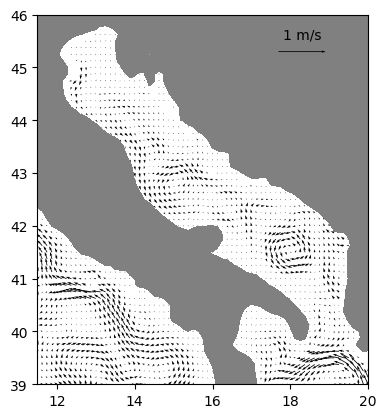

In [5]:
ds = Dataset(outfilename);

u = nomissing(ds["u"][:,:,1,1],NaN);
v = nomissing(ds["v"][:,:,1,1],NaN);
uvlon = nomissing(ds["lon"][:]);
uvlat = nomissing(ds["lat"][:])
close(ds)

figure();
r = 2; 
aspect_ratio = 1/cos(mean(latr) * pi/180)
gca().set_aspect(aspect_ratio)
qq = quiver(uvlon[1:r:end],uvlat[1:r:end],u[1:r:end,1:r:end]',v[1:r:end,1:r:end]', label ="currents"); 
xlim(extrema(bx))
ylim(extrema(by))
contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]]);  
quiverkey(qq,0.8,0.9,1,"1 m/s");


Download and check data

In [6]:
datadir = "./Adriatic/"
smalldatafile = joinpath(datadir, "AdriaticSea_SDC_1000.txt")
datafile = joinpath(datadir, "AdriaticSea_SDC.txt")
if !isdir(datadir)
    @info("Creating data directory")
    mkdir(datadir)
end

if !isfile(smalldatafile)
    @info("Downloading test data file (1000 lines)")
    download("https://dox.ulg.ac.be/index.php/s/FtJdbLDk11buP47/download", smalldatafile)
else
    @info("Data file already downloaded")
end

if !isfile(datafile)
    @info("Downloading data file")
    download("https://dox.ulg.ac.be/index.php/s/A4Eu9nEoovYLtGr/download", datafile)
else
    @info("Data file already downloaded")
end



@time obsval,obslon,obslat,obsdepth,obstime,obsid = ODVspreadsheet.load(Float64,[smalldatafile],
                                                                        ["Water body salinity"]; nametype = :localname );


checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

┌ Info: Data file already downloaded
└ @ Main In[6]:13
┌ Info: Data file already downloaded
└ @ Main In[6]:20
┌ Info: Reading data from file ./Adriatic/AdriaticSea_SDC_1000.txt
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:76
┌ Info: No. of profiles in the file: 79
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:253
┌ Info: Working on variable Water body salinity
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:777
┌ Info: Starting loop on the 79 profiles
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:794


  2.116901 seconds (7.73 M allocations: 372.390 MiB, 3.56% gc time)


┌ Info: Done reading the profiles
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:836


              minimum and maximum of obs. dimension 1: (12.75, 19.266)
              minimum and maximum of obs. dimension 2: (39.566, 44.8)
              minimum and maximum of obs. dimension 3: (0.0, 1130.0)
              minimum and maximum of obs. dimension 4: (1977-02-13T06:00:00, 1978-10-07T07:00:00)
                          minimum and maximum of data: (30.559999, 38.967999)


┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/obsstat.jl:75


In [7]:
@show length(obslon);
@show length(obslat);
@show length(obsval);
@show length(obstime);
@show length(obsid);

length(obslon) = 916
length(obslat) = 916
length(obsval) = 916
length(obstime) = 916
length(obsid) = 916


Prepare the mask a before

In [8]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show size(mask)


grid_bx = [i for i in bx, j in by];
grid_by = [j for i in bx, j in by];

mask_edit = copy(mask);
sel_mask1 = (grid_by .<= 42.6) .& (grid_bx .<= 14.);
sel_mask2 = (grid_by .<= 41.2) .& (grid_bx .<= 16.2);
mask_edit = mask_edit .* .!sel_mask1 .* .!sel_mask2;
@show size(mask_edit)

size(mask) = (69, 57, 3)
size(mask_edit) = (69, 57, 3)


(69, 57, 3)

Make a simple range check

In [9]:
sel = (obsval .<= 40) .& (obsval .>= 25);

obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];

Parameter for the analysis

In [10]:
#@time rdiag=1.0./DIVAnd.weight_RtimesOne((obslon,obslat),(0.03,0.03));
#@show maximum(rdiag),mean(rdiag)

sz = (length(lonr),length(latr),length(depthr));
lenx = fill(100_000.,sz)   # 100 km
leny = fill(100_000.,sz)   # 100 km
lenz = fill(25.,sz);      # 25 m
len = (lenx, leny, lenz);
epsilon2 = 0.1;
#epsilon2 = epsilon2 * rdiag;

filename = "Water_body_$(replace(varname," "=>"_"))_Adriatic_advection_constraint.4Danl.nc"

"Water_body_Salinity_Adriatic_advection_constraint.4Danl.nc"

In [11]:
figdir = "./Adriatic/figures/"
if ~(isdir(figdir))
    mkdir(figdir)
else
    @info("Figure directory already exists")
end

function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    #for i in 1:nz
    for i in 1:1
        #figure("Adriatic-Additional-Data")
        figure()
        ax = subplot(1,1,1)
        ax.tick_params("both",labelsize=6)
        ylim(39.0, 46.0);
        xlim(11.5, 20.0);
        title("Depth: $(depthr[i]) \n Time index: $(timeindex)", fontsize=6)
        pcolor(lonr.-dx/2.,latr.-dy/2, permutedims(tmp[:,:,i], [2,1]);
               vmin = 33, vmax = 40)
        colorbar(extend="both", orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)

        contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
        gca().set_aspect(aspect_ratio)

        figname = varname * @sprintf("_%02d",i) * @sprintf("_%03d_advection_constraint.png",timeindex)
        PyPlot.savefig(joinpath(figdir, figname), dpi=600, bbox_inches="tight");
        #PyPlot.close_figs()
    end
end

┌ Info: Figure directory already exists
└ @ Main In[11]:5


plotres (generic function with 1 method)

In [14]:
?DIVAnd.velocityfile

```
fun = velocityfile(fname,(varnameu,varnamev),TSvelocity,scale)
fun = velocityfile(fname,(varnameu,varnamev,varnamew),TSvelocity,scale)
```

Return a function `fun` which is used in DIVAnd as a advection constraint using fields defined in the NetCDF variable `varnameu`, `varnamev` and `varnamew`  (zonal, meridional and vertical velocity components) in the NetCDF file `fname`. If the parameter `varnamew` is omitted, the vertical velicity is neglected. It is assumed that the NetCDF variables has the variable `lon`, `lat` and `depth` and that the fields have been average according to the provided time selector `TSvelocity` (`TimeSelectorYearListMonthList` or `TimeSelectorRunningAverage`).

See also `DIVAnd.average_files`.

!!! note
    NetCDF _FillValues are treated as zeros.



┌ Info: Creating netCDF file
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:330
┌ Info: Time step 1 / 1
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:382
┌ Info: scaled correlation length (min,max) in dimension 1: (100000.0, 100000.0)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:567
┌ Info: scaled correlation length (min,max) in dimension 2: (100000.0, 100000.0)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:567
┌ Info: scaled correlation length (min,max) in dimension 3: (25.0, 25.0)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:567
┌ Info: analysis uses the velocity time index 1
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/utils.jl:849
┌ Info: number of windows: 1
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/DIVAndgo.jl:111
┌ Warning: There is an advection constraint; make sure the window sizes are large enough for the increased correlation length
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/

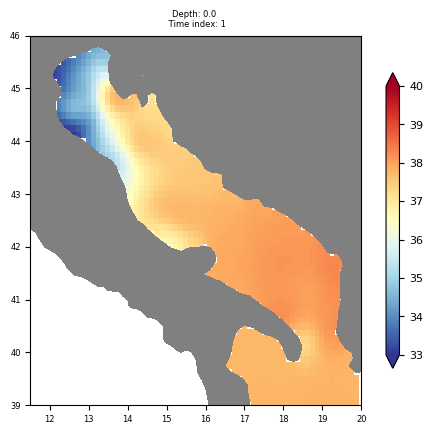

 40.419798 seconds (147.30 M allocations: 7.702 GiB, 6.43% gc time)


In [15]:
TS = TSvelocity
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end
@time dbinfo = diva3d((lonr,latr,depthr,TS),
                      (obslon,obslat,obsdepth,obstime), obsval,
                      len, epsilon2 / 50,
                      filename,varname,
                      bathname=bathname,
                      plotres = plotres,
                      mask = mask_edit,
                      fitcorrlen = false,
                      surfextend = true,
                      velocity = DIVAnd.velocityfile(outfilename,("u","v"),TSvelocity,24*60*60*10),
                      );